<a href="https://colab.research.google.com/github/Maryam-1/Circle-Detection-ML-Challenge-/blob/main/Circle_Detection_ML_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circle Detection ML Challenge

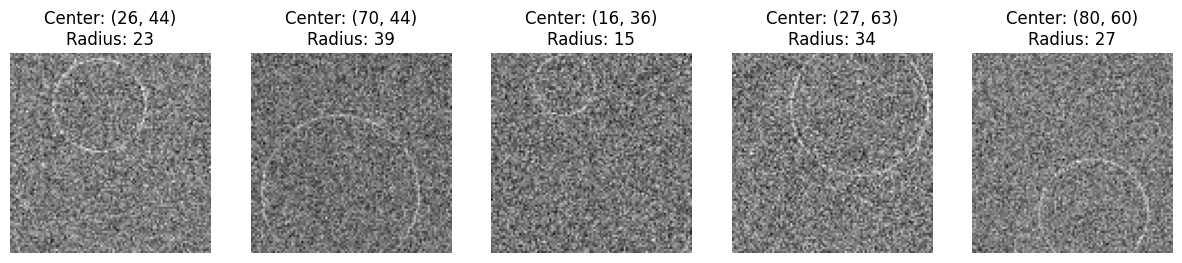

Epoch 1/20
250/250 [==============================] - 59s 232ms/step - loss: 626.6165 - val_loss: 621.9122
Epoch 2/20
250/250 [==============================] - 57s 229ms/step - loss: 464.2304 - val_loss: 368.5781
Epoch 3/20
250/250 [==============================] - 55s 218ms/step - loss: 277.3275 - val_loss: 288.2105
Epoch 4/20
250/250 [==============================] - 57s 229ms/step - loss: 188.8928 - val_loss: 285.0600
Epoch 5/20
250/250 [==============================] - 58s 231ms/step - loss: 127.9760 - val_loss: 291.7822
Epoch 6/20
250/250 [==============================] - 59s 236ms/step - loss: 83.5490 - val_loss: 267.3225
Epoch 7/20
250/250 [==============================] - 58s 234ms/step - loss: 54.9061 - val_loss: 269.2401
Epoch 8/20
250/250 [==============================] - 58s 231ms/step - loss: 32.3038 - val_loss: 277.7590
Epoch 9/20
250/250 [==============================] - 57s 229ms/step - loss: 19.8649 - val_loss: 279.8020
Epoch 10/20
250/250 [====================

In [5]:
import numpy as np
from skimage.draw import circle_perimeter_aa
from typing import NamedTuple, Tuple, Optional, Generator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Define CircleParams class
class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int

# Function to draw a circle
def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img

# Function to generate noisy circles
def noisy_circle(img_size: int, min_radius: float, max_radius: float, noise_level: float) -> Tuple[np.ndarray, CircleParams]:
    img = np.zeros((img_size, img_size))
    radius = np.random.randint(min_radius, max_radius)
    row, col = np.random.randint(img_size, size=2)
    draw_circle(img, row, col, radius)
    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise
    return img, CircleParams(row, col, radius)

# Generator function for examples
def generate_examples(noise_level: float = 0.5, img_size: int = 100, min_radius: Optional[int] = None, max_radius: Optional[int] = None) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    while True:
        img, params = noisy_circle(img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level)
        yield img, params

def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return 0.0
    if d <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is
        # inside the other
        larger_r, smaller_r = max(r1, r2), min(r1, r2)
        return smaller_r ** 2 / larger_r ** 2
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    sector_area1 = r1_sq * np.arccos(d1 / r1)
    triangle_area1 = d1 * np.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * np.arccos(d2 / r2)
    triangle_area2 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

# Data collection function
def collect_data(generator, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    images = np.zeros((num_samples, 100, 100, 1))
    labels = np.zeros((num_samples, 3))

    for i in range(num_samples):
        img, params = next(generator)
        images[i, :, :, 0] = img
        labels[i] = [params.row, params.col, params.radius]

    return images, labels

# Function to visualize some generated examples
def visualize_data(generator, num_samples: int = 5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, params = next(generator)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Center: ({params.row}, {params.col})\nRadius: {params.radius}")
        axes[i].axis('off')
    plt.show()

# Simplified CNN model
def create_cnn_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 1)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3)  # x, y, radius
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Main script
if __name__ == "__main__":
    # Visualize data
    gen = generate_examples()
    visualize_data(gen)

    # Generate and split data
    images, labels = collect_data(gen, 10000)  # Generate 10000 samples
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2)

    # Create and train the model
    model = create_cnn_model()
    history = model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), batch_size=32)

    # Evaluate the model
    test_gen = generate_examples()
    test_images, test_labels = collect_data(test_gen, 1000)  # Generate 1000 test samples
    predictions = model.predict(test_images)
    ious = [iou(CircleParams(*test_labels[i]), CircleParams(*predictions[i])) for i in range(len(test_labels))]
    print(f'Model IOU Performance: {np.mean(ious)}')
